In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg
import requests

%matplotlib inline

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 100)

plt.style.use('ggplot') # Make the graphs a bit prettier

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.family'] = 'sans-serif'

# Pivoting table

Pivoting table so the indexes would be participant id and row data is step count

In [3]:
fitness = pd.read_csv('data/processed/nsc1_fitness.csv',
                          na_values='Nan',
                          parse_dates=['ActivityDate'],
                          dtype={'ParticipantId': np.int})

In [4]:
widened = fitness.pivot(columns='ActivityDate', index='ParticipantId', values='StepCount')

In [6]:
widened.head()

ActivityDate   2015-10-01  2015-10-02  2015-10-03  2015-10-04  2015-10-05  2015-10-06  2015-10-07  2015-10-08  2015-10-09  2015-10-10  2015-10-11  2015-10-12  2015-10-13  2015-10-14  2015-10-15  2015-10-16  2015-10-17  2015-10-18  2015-10-19  2015-10-20  2015-10-21  2015-10-22  2015-10-23  2015-10-24  2015-10-25  2015-10-26  2015-10-27  2015-10-28  2015-10-29  2015-10-30  2015-10-31  2015-11-01  2015-11-02  2015-11-03  2015-11-04  2015-11-05  2015-11-06  2015-11-07  2015-11-08  2015-11-09  2015-11-10  2015-11-11  2015-11-12  2015-11-13  2015-11-14  2015-11-15  2015-11-16  2015-11-17  2015-11-18  2015-11-19     ...      2016-06-12  2016-06-13  2016-06-14  2016-06-15  2016-06-16  2016-06-17  2016-06-18  2016-06-19  2016-06-20  2016-06-21  2016-06-22  2016-06-23  2016-06-24  2016-06-25  2016-06-26  2016-06-27  2016-06-28  2016-06-29  2016-06-30  2016-07-01  2016-07-02  2016-07-03  2016-07-04  2016-07-05  2016-07-06  2016-07-07  2016-07-08  2016-07-09  2016-07-10  2016-07-11  2016-07-12  2016-07-13  2016-07-14  2016-07-15  2016-07-16  2016-07-17  2016-07-18  2016-07-19  2016-07-20  2016-07-21  2016-07-22  2016-07-23  2016-07-24  2016-07-25  2016-07-26  2016-07-27  2016-07-28  2016-07-29  2016-07-30  2016-07-31
ParticipantId                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1000097               NaN         NaN         NaN      5516.0      5139.0      1904.0      4592.0      5935.0      5580.0      5415.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN     ...             NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN
1000157               NaN      9364.0      7145.0      3273.0     10779.0      5666.0      6323.0       257.0      8604.0     12570.0      5976.0      5666.0      5464.0      4843.0      7027.0      6047.0         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         NaN         

In [7]:
widened = widened.fillna(0)

In [8]:
stacked_windened = widened.stack()
stacked_windened.head()

ParticipantId  ActivityDate
1000097        2015-10-01         0.0
               2015-10-02         0.0
               2015-10-03         0.0
               2015-10-04      5516.0
               2015-10-05      5139.0
dtype: float64

In [ ]:
widened.to_csv('data/processed/widened.csv')

# Extend participant

Extend participant table with location infomation and also fitness info.

## Read participant raw data

In [10]:
nsc1_participant = pd.read_csv('data/processed/nsc1_participant.csv',
                              encoding='latin1',
                              dtype={'Id': np.int, 
                                     'PostalCode': str})
nsc1_participant.head()

Id  ServiceId                                          PushToken Gender PostalCode  Weight  Height  StepsLastWeek  ActiveTimeLastWeek  DistanceLastWeek  TargetSteps  TargetCalories AppVersion DeviceBrand DeviceModel  OptInSurvey          CreateAt          UpdateAt WearableId WearableAttachedAt WearableDetachedAt  TargetWeight                     EncID
0  1020516          1  APA91bFvzrQJ02NgKei3ihBphUPAOdtxoug4DRzakGPIUd...      M     541265      93     176              0                  30                 0            0               0      1.0.9        asus   ASUS_Z00A            0  15OCT15:17:24:31  20NOV15:14:42:13        NaN                NaN                NaN           0.0  kIQNtc18wnx4n0x3bxHi1Q==
1  1167753          1  APA91bEcvLOr9iVivpJw79h5dhXUjqX_l-dNvflIWDkkr-...      M     648927       0       0              0                 600                 0            0               0      2.0.2        asus   ASUS_T00J            0  07DEC15:17:08:30  07DEC15:17:16:04        NaN                NaN                NaN           0.0  wq1EmzMOKpg1EFxxvfmHUQ==
2  1158020          1  APA91bHMzY0qKOhiZPij-1_8zrrN8Eslcuk0_b98YxYDGM...      M        NaN      54     180              0                  60                 0            0               0      2.0.2        asus   ASUS_Z00A            0  03DEC15:08:41:34  03DEC15:08:57:18        NaN                NaN                NaN           0.0  Ddlema7tqy40SoAaHONIVg==
3  1152416          1  APA91bEtvSBerAjqPK0LKb2AK3xf8XezKrenXs6yuxfWYx...      F     460075       0       0              0                  60                 0            0               0      2.0.1        asus   ASUS_Z002            0  30NOV15:23:23:54  30NOV15:23:30:19        NaN                NaN                NaN           0.0  fJuZnc/VCfgEesvXxwpFDw==
4  1160124          1  APA91bFjnHRtfb9tNjXW70u-724baciCtJ6ATxyNCCrr57...      F        NaN      46     148              0                   5                 0            0               0      2.0.2        asus   ASUS_Z002            0  04DEC15:01:19:58  04DEC15:19:00:54        NaN                NaN                NaN           0.0  FUOa7lM75EgdoFVagQQ8nw==

## Add location and distance data

In [18]:
# Create a database connection to postgis
postgis_con = pg.connect(database='postgres', user='postgres', host='localhost')

In [26]:
# Query the distance to the nearst bus stop for each postal code
#distance_to_bus_stop_sql = 'select pb_distance.postalcode, min(pb_distance.distance) as min_busstop_distance from (SELECT p.postalcode as postalcode, b.name as stopname, st_distance(p.geoloc, b.geoloc) as distance from postal_code_svy21 p, bus_stop b) as pb_distance GROUP BY pb_distance.postalcode'
distance_to_bus_stop_sql = 'select * from nearest_busstop'
bus_stop_distance = pd.read_sql(distance_to_bus_stop_sql, con=postgis_con)
bus_stop_distance = bus_stop_distance.rename(columns={'min': 'bus_stop_distance'})
bus_stop_distance.head(1)

postalcode  bus_stop_distance
0     486365          67.059226

In [28]:
# Query the distance to the nearst train station for each postal code
# distance_to_train_station_sql = 'select pb_distance.postalcode, min(pb_distance.distance) as min_train_distance from (SELECT p.postalcode as postalcode, st_distance(p.geoloc, b.geoloc) as distance from postal_code_svy21 p, train_station b) as pb_distance GROUP BY pb_distance.postalcode;'
distance_to_train_station_sql = 'select * from nearest_trainstation'
train_station_distance = pd.read_sql(distance_to_train_station_sql, con=postgis_con)
train_station_distance = train_station_distance.rename(columns={'distance': 'train_station_distance'})
train_station_distance.head(1)

postalcode  train_station_distance
0     486365              1248.64671

In [29]:
# Query the distance to the nearst train station for each postal code
# distance_to_park_sql = 'select pb_distance.postalcode, min(pb_distance.distance) as min_park_distance from (SELECT p.postalcode as postalcode, st_distance(p.geoloc, b.geoloc) as distance from postal_code_svy21 p, parks b) as pb_distance GROUP BY pb_distance.postalcode;'
distance_to_park_sql = 'select * from nearest_park'
park_distance = pd.read_sql(distance_to_park_sql, con=postgis_con)
park_distance = park_distance.rename(columns={'distance': 'park_distance'})
park_distance.head(1)

postalcode  park_distance
0     486365     304.204927

In [22]:
postal_code_sql = 'select * from postal_code;'
postal_code = pd.read_sql(postal_code_sql, con= postgis_con)
postal_code = postal_code[['postalcode', 'lat', 'lon', 'x', 'y']]
postal_code.head()

postalcode       lat         lon             x             y
0      18960  1.278692  103.851352  30007.016733  29016.822226
1      18965  1.280345  103.852143  30095.036181  29199.570535
2      18980  1.279626  103.854987  30411.542766  29120.049701
3      18982  1.279017  103.854465  30353.404931  29052.732041
4      18985  1.280769  103.852659  30152.382811  29246.505009

In [23]:
len(postal_code)

19821

In [42]:
location_distance = postal_code \
.join(bus_stop_distance.set_index('postalcode'), on='postalcode') \
.join(train_station_distance.set_index('postalcode'), on='postalcode') \
.join(park_distance.set_index('postalcode'), on='postalcode').set_index('postalcode')
location_distance.head(1)

lat         lon             x             y  bus_stop_distance  train_station_distance  park_distance
postalcode                                                                                                            
18960       1.278692  103.851352  30007.016733  29016.822226         169.157055              186.238832     613.605773

In [43]:
len(location_distance)

19821

In [45]:
nsc1_participant_loc = nsc1_participant.join(location_distance, on='PostalCode')
nsc1_participant_loc.head(1)

Id  ServiceId                                          PushToken Gender PostalCode  Weight  Height  StepsLastWeek  ActiveTimeLastWeek  DistanceLastWeek  TargetSteps  TargetCalories AppVersion DeviceBrand DeviceModel  OptInSurvey          CreateAt          UpdateAt WearableId WearableAttachedAt WearableDetachedAt  TargetWeight                     EncID       lat         lon             x             y  bus_stop_distance  train_station_distance  park_distance
0  1020516          1  APA91bFvzrQJ02NgKei3ihBphUPAOdtxoug4DRzakGPIUd...      M     541265      93     176              0                  30                 0            0               0      1.0.9        asus   ASUS_Z00A            0  15OCT15:17:24:31  20NOV15:14:42:13        NaN                NaN                NaN           0.0  kIQNtc18wnx4n0x3bxHi1Q==  1.382268  103.895279  34895.401134  40469.814863         228.666457              249.606197     698.343814

In [46]:
# Verify
len(nsc1_participant_loc), len(nsc1_participant)

(183808, 183808)

In [47]:
nsc1_participant_loc.to_csv('data/processed/nsc1_participant_loc.csv', index=False)

In [52]:
# Clear memory before proceed
try:
    postgis_con.close()
    nsc1_participant = None
    nsc1_participant_loc = None
except:
    pass

## Add step count statistics

In [53]:
fitness = pd.read_csv('data/processed/nsc1_fitness.csv', 
                      na_values='Nan',
                      parse_dates=['ActivityDate'],
                      dtype={'ParticipantId': np.int})
nsc1_participant_loc = pd.read_csv('data/processed/nsc1_participant_loc.csv',
                                   encoding='latin1',
                                   dtype={'Id': np.int,
                                          'PostalCode': str})

In [54]:
total_stepcount = fitness[['ParticipantId','StepCount']] \
.groupby('ParticipantId') \
.aggregate([sum, np.mean, np.std, np.median, np.min, np.max, 'count'])['StepCount']

total_stepcount = total_stepcount.rename(columns={'count':'no_of_active_days'})
total_stepcount.head()

sum         mean          std  median  amin   amax  no_of_active_days
ParticipantId                                                                          
1000097         34081  4868.714286  1372.312855  5415.0  1904   5935                  7
1000157         99004  6600.266667  2969.328386  6047.0   257  12570                 15
1000227        114914  5223.363636  2130.930862  4708.5  1634   9294                 22
1000242        253012  6487.487179  6818.144052  4607.0    13  32439                 39
1000265         67844  8480.500000  3687.489390  9263.0  1075  13321                  8

In [59]:
nsc1_participant_loc_stepcount = nsc1_participant_loc.join(total_stepcount, on='Id')
nsc1_participant_loc_stepcount.head(1)

Id  ServiceId                                          PushToken Gender PostalCode  Weight  Height  StepsLastWeek  ActiveTimeLastWeek  DistanceLastWeek  TargetSteps  TargetCalories AppVersion DeviceBrand DeviceModel  OptInSurvey          CreateAt          UpdateAt WearableId WearableAttachedAt WearableDetachedAt  TargetWeight                     EncID       lat         lon             x             y  bus_stop_distance  train_station_distance  park_distance  sum  mean  std  median  amin  amax  no_of_active_days
0  1020516          1  APA91bFvzrQJ02NgKei3ihBphUPAOdtxoug4DRzakGPIUd...      M     541265      93     176              0                  30                 0            0               0      1.0.9        asus   ASUS_Z00A            0  15OCT15:17:24:31  20NOV15:14:42:13        NaN                NaN                NaN           0.0  kIQNtc18wnx4n0x3bxHi1Q==  1.382268  103.895279  34895.401133  40469.814863         228.666457              249.606197     698.343814  NaN   NaN  NaN     NaN   NaN   NaN                NaN

In [56]:
len(nsc1_participant_loc_stepcount)

183808

In [60]:
nsc1_participant_loc_stepcount.to_csv('data/processed/nsc1_participant_loc_stepcount.csv', index=False)

In [77]:
# Clean memory
nsc1_participant_loc_stepcount = None
nsc1_participant_loc = None
fitness = None

# Add lenght of lifespan

In [ ]:
fitness = pd.read_csv('data/processed/nsc1_fitness.csv', 
                      na_values='Nan',
                      parse_dates=['ActivityDate'],
                      dtype={'ParticipantId': np.int})

In [3]:
nsc1_participant_loc_stepcount = pd.read_csv('data/processed/nsc1_participant_loc_stepcount.csv',
                              na_values='Nan',
                              encoding='latin1',
                              dtype={'Id': np.int, 
                                     'PostalCode': str})

In [15]:
small_fitness = fitness.head()
small_fitness

Unnamed: 0  ParticipantId ActivityDate  StepCount  Distance  TimeBlock  ActiveTimeTotal  ActiveTimeWalk  ActiveTimeRun  ActiveTimeStairs  ActiveTimeCycle  ActiveTimeOther          CreateAt          UpdateAt         Source                     EncID
0           0        1097101   2015-11-21          4         3        0.0                0               0              0                 0                0                0  22NOV15:12:15:17  22NOV15:12:15:17  Accelerometer  2CHR1rBrwqh2khVxilDA+Q==
1           1        1172539   2015-12-10       4886      3908        0.0             2908            2908              0                 0                0                0  11DEC15:09:58:00  11DEC15:09:58:00      GoogleFit  Fl7Oi0DQql7LQ5cvfil4DQ==
2           2        1172539   2015-12-11       3808      3046        0.0             4367            2590              0                 0             1777                0  12DEC15:00:04:23  12DEC15:00:04:23      GoogleFit  Fl7Oi0DQql7LQ5cvfil4DQ==
3           3        1172539   2015-12-12      11630      9304        0.0             8194            8049            145                 0                0                0  14DEC15:09:07:50  14DEC15:09:07:50      GoogleFit  Fl7Oi0DQql7LQ5cvfil4DQ==
4           4        1172539   2015-12-13       2546      2036        0.0             1952            1952              0                 0                0                0  14DEC15:09:07:51  14DEC15:09:07:51      GoogleFit  Fl7Oi0DQql7LQ5cvfil4DQ==

In [71]:
lifespan = fitness.groupby('ParticipantId')['ActivityDate'].aggregate(['max', 'min'])
lifespan['lifespan'] = (lifespan['max'] - lifespan['min'] + pd.to_timedelta(1, unit='d')).dt.days
lifespan = lifespan.rename(columns={'max': 'last_day', 'min': 'first_day'})
lifespan.head(1)

last_day  first_day  lifespan
ParticipantId                                
1000097       2015-10-10 2015-10-04         7

In [72]:
len(lifespan)

156206

In [73]:
nsc1_participant_extended = nsc1_participant_loc_stepcount.join(lifespan, on='Id')

In [74]:
len(nsc1_participant_extended)

183808

In [75]:
nsc1_participant_extended.to_csv('data/processed/nsc1_participant_extended.csv', index=False)

In [76]:
# clean memory
nsc1_participant_loc_stepcount = None
nsc1_participant_extended = None
fitness = None

## Extend participant with nearest weather station data

In [3]:
postgis_con = pg.connect(database='postgres', user='postgres', host='localhost')

# Query the distance to the nearst train station for each postal code
nearst_wst_sql = 'select * from nearest_weatherst'
nearst_wst = pd.read_sql(nearst_wst_sql, con=postgis_con)
nearst_wst.head()

postalcode st_code    distance
0      18960     S72  634.939324
1      18965     S72  836.491941
2      18980     S72  983.881145
3      18982     S72  896.135708
4      18985     S72  906.739264

In [6]:
nsc1_participant_extended = pd.read_csv('data/processed/nsc1_participant_extended.csv',
                                        na_values='Nan',
                                        encoding='latin1',
                                        dtype={'Id': np.int, 'PostalCode': str})
nsc1_participant_extended.head()

Id  ServiceId                                          PushToken Gender PostalCode  Weight  Height  StepsLastWeek  ActiveTimeLastWeek  DistanceLastWeek  TargetSteps  TargetCalories AppVersion DeviceBrand DeviceModel  OptInSurvey          CreateAt          UpdateAt WearableId WearableAttachedAt WearableDetachedAt  TargetWeight                     EncID       lat         lon             x             y  bus_stop_distance  train_station_distance  park_distance  sum  mean  std  median  amin  amax  no_of_active_days last_day first_day  lifespan
0  1020516          1  APA91bFvzrQJ02NgKei3ihBphUPAOdtxoug4DRzakGPIUd...      M     541265      93     176              0                  30                 0            0               0      1.0.9        asus   ASUS_Z00A            0  15OCT15:17:24:31  20NOV15:14:42:13        NaN                NaN                NaN           0.0  kIQNtc18wnx4n0x3bxHi1Q==  1.382268  103.895279  34895.401134  40469.814863         228.666457              249.606197     698.343814  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN
1  1167753          1  APA91bEcvLOr9iVivpJw79h5dhXUjqX_l-dNvflIWDkkr-...      M     648927       0       0              0                 600                 0            0               0      2.0.2        asus   ASUS_T00J            0  07DEC15:17:08:30  07DEC15:17:16:04        NaN                NaN                NaN           0.0  wq1EmzMOKpg1EFxxvfmHUQ==  1.341838  103.718353  15205.512108  35999.391062         261.311492              395.590705     196.958272  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN
2  1158020          1  APA91bHMzY0qKOhiZPij-1_8zrrN8Eslcuk0_b98YxYDGM...      M        NaN      54     180              0                  60                 0            0               0      2.0.2        asus   ASUS_Z00A            0  03DEC15:08:41:34  03DEC15:08:57:18        NaN                NaN                NaN           0.0  Ddlema7tqy40SoAaHONIVg==       NaN         NaN           NaN           NaN                NaN                     NaN            NaN  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN
3  1152416          1  APA91bEtvSBerAjqPK0LKb2AK3xf8XezKrenXs6yuxfWYx...      F     460075       0       0              0                  60                 0            0               0      2.0.1        asus   ASUS_Z002            0  30NOV15:23:23:54  30NOV15:23:30:19        NaN                NaN                NaN           0.0  fJuZnc/VCfgEesvXxwpFDw==  1.327915  103.942144  40111.213594  34459.852808         225.011103              495.482985     540.757563  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN
4  1160124          1  APA91bFjnHRtfb9tNjXW70u-724baciCtJ6ATxyNCCrr57...      F        NaN      46     148              0                   5                 0            0               0      2.0.2        asus   ASUS_Z002            0  04DEC15:01:19:58  04DEC15:19:00:54        NaN                NaN                NaN           0.0  FUOa7lM75EgdoFVagQQ8nw==       NaN         NaN           NaN           NaN                NaN                     NaN            NaN  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN

In [7]:
nsc1_participant_extended = nsc1_participant_extended.join(nearst_wst[['postalcode', 'st_code']].set_index('postalcode'), on='PostalCode')
nsc1_participant_extended.head()

Id  ServiceId                                          PushToken Gender PostalCode  Weight  Height  StepsLastWeek  ActiveTimeLastWeek  DistanceLastWeek  TargetSteps  TargetCalories AppVersion DeviceBrand DeviceModel  OptInSurvey          CreateAt          UpdateAt WearableId WearableAttachedAt WearableDetachedAt  TargetWeight                     EncID       lat         lon             x             y  bus_stop_distance  train_station_distance  park_distance  sum  mean  std  median  amin  amax  no_of_active_days last_day first_day  lifespan st_code
0  1020516          1  APA91bFvzrQJ02NgKei3ihBphUPAOdtxoug4DRzakGPIUd...      M     541265      93     176              0                  30                 0            0               0      1.0.9        asus   ASUS_Z00A            0  15OCT15:17:24:31  20NOV15:14:42:13        NaN                NaN                NaN           0.0  kIQNtc18wnx4n0x3bxHi1Q==  1.382268  103.895279  34895.401134  40469.814863         228.666457              249.606197     698.343814  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN     S55
1  1167753          1  APA91bEcvLOr9iVivpJw79h5dhXUjqX_l-dNvflIWDkkr-...      M     648927       0       0              0                 600                 0            0               0      2.0.2        asus   ASUS_T00J            0  07DEC15:17:08:30  07DEC15:17:16:04        NaN                NaN                NaN           0.0  wq1EmzMOKpg1EFxxvfmHUQ==  1.341838  103.718353  15205.512108  35999.391062         261.311492              395.590705     196.958272  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN    S101
2  1158020          1  APA91bHMzY0qKOhiZPij-1_8zrrN8Eslcuk0_b98YxYDGM...      M        NaN      54     180              0                  60                 0            0               0      2.0.2        asus   ASUS_Z00A            0  03DEC15:08:41:34  03DEC15:08:57:18        NaN                NaN                NaN           0.0  Ddlema7tqy40SoAaHONIVg==       NaN         NaN           NaN           NaN                NaN                     NaN            NaN  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN     NaN
3  1152416          1  APA91bEtvSBerAjqPK0LKb2AK3xf8XezKrenXs6yuxfWYx...      F     460075       0       0              0                  60                 0            0               0      2.0.1        asus   ASUS_Z002            0  30NOV15:23:23:54  30NOV15:23:30:19        NaN                NaN                NaN           0.0  fJuZnc/VCfgEesvXxwpFDw==  1.327915  103.942144  40111.213594  34459.852808         225.011103              495.482985     540.757563  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN     S84
4  1160124          1  APA91bFjnHRtfb9tNjXW70u-724baciCtJ6ATxyNCCrr57...      F        NaN      46     148              0                   5                 0            0               0      2.0.2        asus   ASUS_Z002            0  04DEC15:01:19:58  04DEC15:19:00:54        NaN                NaN                NaN           0.0  FUOa7lM75EgdoFVagQQ8nw==       NaN         NaN           NaN           NaN                NaN                     NaN            NaN  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN     NaN

In [8]:
nsc1_participant_extended.to_csv('data/processed/nsc1_participant_fullextended.csv', index=False)

# Add the number of parks nearby

In [3]:
nsc1_participant_extended = pd.read_csv('data/processed/nsc1_participant_extended.csv',
                                        na_values='Nan',
                                        encoding='latin1',
                                        dtype={'Id': np.int, 'PostalCode': str})
nsc1_participant_extended.head()

Id  ServiceId                                          PushToken Gender PostalCode  Weight  Height  StepsLastWeek  ActiveTimeLastWeek  DistanceLastWeek  TargetSteps  TargetCalories AppVersion DeviceBrand DeviceModel  OptInSurvey          CreateAt          UpdateAt WearableId WearableAttachedAt WearableDetachedAt  TargetWeight                     EncID       lat         lon             x             y  bus_stop_distance  train_station_distance  park_distance  sum  mean  std  median  amin  amax  no_of_active_days last_day first_day  lifespan
0  1020516          1  APA91bFvzrQJ02NgKei3ihBphUPAOdtxoug4DRzakGPIUd...      M     541265      93     176              0                  30                 0            0               0      1.0.9        asus   ASUS_Z00A            0  15OCT15:17:24:31  20NOV15:14:42:13        NaN                NaN                NaN           0.0  kIQNtc18wnx4n0x3bxHi1Q==  1.382268  103.895279  34895.401134  40469.814863         228.666457              249.606197     698.343814  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN
1  1167753          1  APA91bEcvLOr9iVivpJw79h5dhXUjqX_l-dNvflIWDkkr-...      M     648927       0       0              0                 600                 0            0               0      2.0.2        asus   ASUS_T00J            0  07DEC15:17:08:30  07DEC15:17:16:04        NaN                NaN                NaN           0.0  wq1EmzMOKpg1EFxxvfmHUQ==  1.341838  103.718353  15205.512108  35999.391062         261.311492              395.590705     196.958272  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN
2  1158020          1  APA91bHMzY0qKOhiZPij-1_8zrrN8Eslcuk0_b98YxYDGM...      M        NaN      54     180              0                  60                 0            0               0      2.0.2        asus   ASUS_Z00A            0  03DEC15:08:41:34  03DEC15:08:57:18        NaN                NaN                NaN           0.0  Ddlema7tqy40SoAaHONIVg==       NaN         NaN           NaN           NaN                NaN                     NaN            NaN  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN
3  1152416          1  APA91bEtvSBerAjqPK0LKb2AK3xf8XezKrenXs6yuxfWYx...      F     460075       0       0              0                  60                 0            0               0      2.0.1        asus   ASUS_Z002            0  30NOV15:23:23:54  30NOV15:23:30:19        NaN                NaN                NaN           0.0  fJuZnc/VCfgEesvXxwpFDw==  1.327915  103.942144  40111.213594  34459.852808         225.011103              495.482985     540.757563  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN
4  1160124          1  APA91bFjnHRtfb9tNjXW70u-724baciCtJ6ATxyNCCrr57...      F        NaN      46     148              0                   5                 0            0               0      2.0.2        asus   ASUS_Z002            0  04DEC15:01:19:58  04DEC15:19:00:54        NaN                NaN                NaN           0.0  FUOa7lM75EgdoFVagQQ8nw==       NaN         NaN           NaN           NaN                NaN                     NaN            NaN  NaN   NaN  NaN     NaN   NaN   NaN                NaN      NaN       NaN       NaN

In [6]:
postgis_con = pg.connect(database='postgres', user='postgres', host='localhost')
park_sql = 'select * from park_around'
park = pd.read_sql(park_sql, con=postgis_con)
# park = park_distance.rename(columns={'distance': 'park_distance'})
postgis_con.close()
park.head(1)

postalcode  park_count
0     486365           9

In [9]:
nsc1_participant_extended = nsc1_participant_extended.join(park.set_index('postalcode'), on='PostalCode')

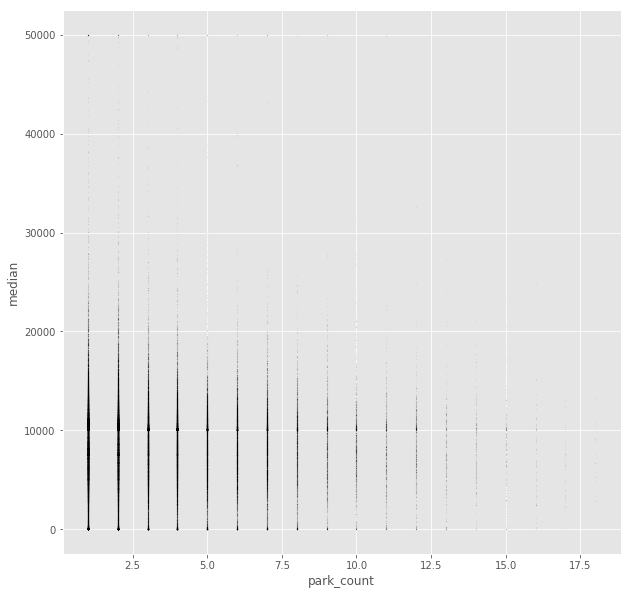

In [10]:
nsc1_participant_extended[['median', 'park_count']]\
.plot.scatter(x='park_count', y='median', alpha=0.05, s=0.5, color='black')

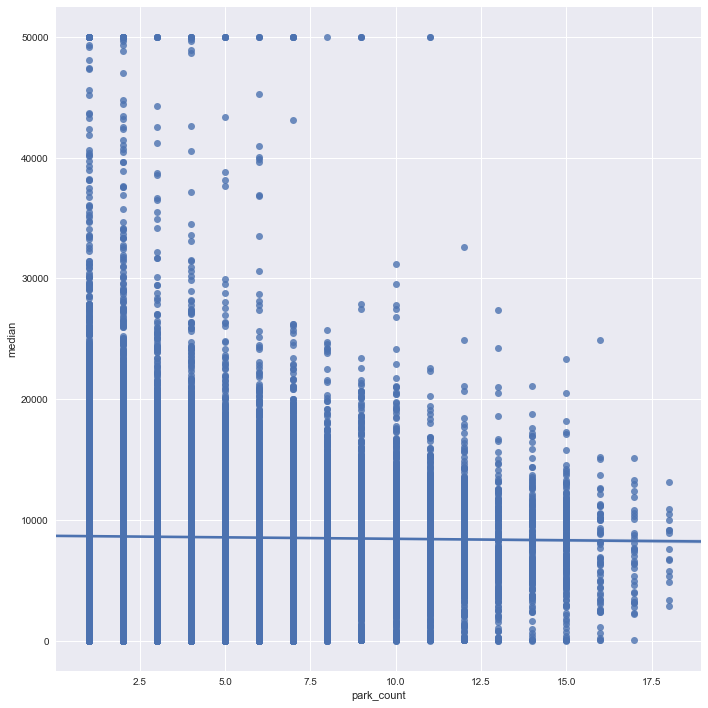

In [12]:
import seaborn as sns
sns.lmplot(x='park_count', y='median', size=10,
           data=nsc1_participant_extended[['median', 'park_count']],fit_reg=True) 